<a href="https://colab.research.google.com/github/shah-zeb-naveed/autogen-udemy-course/blob/main/image_generator_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyautogen[lmm] --upgrade -q

In [ ]:
# snippets borrowed from https://microsoft.github.io/autogen/docs/notebooks/agentchat_image_generation_capability/
import os
import re
from typing import Dict, Optional

from IPython.display import display
from PIL.Image import Image

import autogen
from autogen import (
    Agent,
    AssistantAgent,
    ConversableAgent,
    GroupChat,
    GroupChatManager,
    UserProxyAgent
)
from autogen.agentchat.contrib import img_utils
from autogen.agentchat.contrib.capabilities import generate_images
from autogen.cache import Cache
from autogen.oai import openai_utils

from google.colab import userdata

In [ ]:
# define configs for models

gpt_config = {
    "config_list": [{"model": "gpt-3.5-turbo", "api_key": userdata.get("OPENAI_API_KEY")}],
    "timeout": 120,
    "temperature": 0.5,
}

gpt_vision_config = {
    "config_list": [{"model": "gpt-4-vision-preview", "api_key": userdata.get("OPENAI_API_KEY")}],
    "timeout": 120,
    "temperature": 0.5,
}

dalle_config = {
    "config_list": [{"model": "dall-e-2", "api_key": userdata.get("OPENAI_API_KEY")}],
    "timeout": 120,
    "temperature": 0.5,
}

In [ ]:
# create image generator agent
agent = autogen.ConversableAgent(
    name="agent_with_dalle_capability",
    llm_config=gpt_vision_config,
    max_consecutive_auto_reply=2,
    human_input_mode="NEVER"
)

# define image generation capability
dalle_gen = generate_images.DalleImageGenerator(llm_config=dalle_config, resolution='256x256')
image_gen_capability = generate_images.ImageGeneration(
    image_generator=dalle_gen,
    text_analyzer_llm_config=gpt_config,
    verbosity=2
)

# add ability
image_gen_capability.add_to_agent(agent)

In [ ]:
user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    code_execution_config=False
)

user_proxy (to agent_with_dalle_capability):

imagine kittens playing with a ball of yarn

--------------------------------------------------------------------------------
agent_with_dalle_capability (to user_proxy):

I generated an image with the prompt: Kittens playing with a ball of yarn.<image>

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'imagine kittens playing with a ball of yarn', 'role': 'assistant'}, {'content': [{'type': 'text', 'text': 'I generated an image with the prompt: Kittens playing with a ball of yarn.'}, {'type': 'image_url', 'image_url': {'url': ''}}], 'role': 'user'}], summary='I generated an image with the prompt: Kittens playing with a ball of yarn.', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])
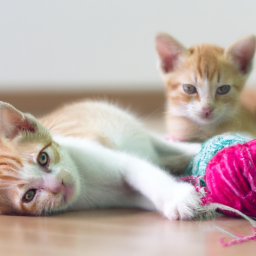

In [ ]:
reply = user_proxy.initiate_chat(agent, message='imagine kittens playing with a ball of yarn', max_turns=1)#.generate_reply('A dog')
reply

You might get errors like {'content': "Sorry, I can't generate images."}. This happens because of filtering on OpenAI's end which is too restrictive. You can try different/less controversial prompts

In [ ]:
def extract_images(sender, recipient):
    images = []
    all_messages = sender.chat_messages[recipient]

    for message in reversed(all_messages):
        # The GPT-4V format, where the content is an array of data
        contents = message.get("content", [])
        for content in contents:
            if isinstance(content, str):
                continue
            if content.get("type", "") == "image_url":
                img_data = content["image_url"]["url"]
                images.append(img_utils.get_pil_image(img_data))

    if not images:
        raise ValueError("No image data found in messages.")

    return images

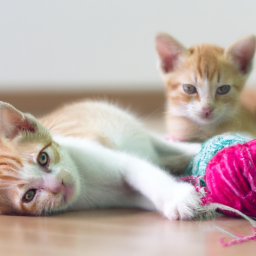

In [ ]:
images = extract_images(agent, user_proxy)
display(images[0])

# Scenario: Critic Agent

In [ ]:
CRITIC_SYSTEM_MESSAGE = """To enhance the quality of the generated
images, consider refining the prompt provided to the DALL-E agent.
Provide suggestions for improving aspects such as color, shape, text
clarity, and other relevant factors. Use the following format when
responding:

CRITICS: [Specify areas for improvement]
PROMPT: [Insert updated prompt here]

If you have no critique or a new prompt to offer, just type TERMINATE.
"""


def get_critic_agent():
    critic_agent = ConversableAgent(
        name="critic",
        llm_config=gpt_vision_config,
        system_message=CRITIC_SYSTEM_MESSAGE,
        max_consecutive_auto_reply=2,
        human_input_mode="NEVER"
    )

    return critic_agent


image_generator_agent = agent
critic_agent = get_critic_agent()

prompt = "Create an image of two robots talking to each other"

result = critic_agent.initiate_chat(
    image_generator_agent,
    message=prompt
)

critic (to agent_with_dalle_capability):

Create an image of two robots talking to each other

--------------------------------------------------------------------------------
agent_with_dalle_capability (to critic):

I generated an image with the prompt: Two robots engaging in conversation, one possibly larger or more advanced than the other, set in a futuristic environment with a mix of metallic and digital elements.<image>

--------------------------------------------------------------------------------
critic (to agent_with_dalle_capability):

The image you've created successfully depicts two robots engaging in conversation. The larger robot does indeed appear more advanced, and the environment has a futuristic feel with metallic and digital elements as described. The lighting and color contrast add depth to the scene, emphasizing the futuristic atmosphere.

CRITICS: The robots are well-differentiated in size and complexity, but the image could benefit from a clearer distinction in

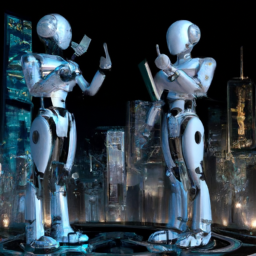

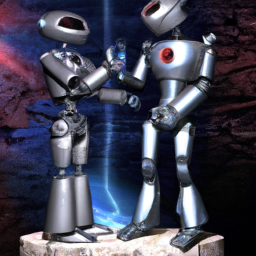

In [ ]:
images = extract_images(agent, critic_agent)

for image in images:
  display(image)